In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape, test.shape

((42000, 785), (28000, 784))

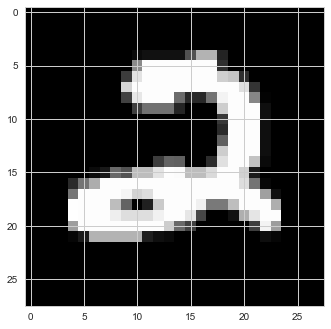

In [3]:
# 使用ndarray，而不是DataFrame
train_images = train.iloc[:, 1:].values
train_labels = train.iloc[:, 0].values
test_images = test.iloc[:].values

plt.imshow(test_images[0].reshape(28, 28), cmap='gray')

# SVM

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

SAMPLE_SIZE = 5000
X_all = train_images[:SAMPLE_SIZE].copy()
y_all = train_labels[:SAMPLE_SIZE].copy()
X_test = test_images[:].copy()

# sharpen
X_all[X_all < 32] = 0
X_all[X_all >= 32] = 1
X_test[X_test < 32] = 0
X_test[X_test >= 32] = 1

X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size = 0.3)

svc = SVC()
svc.fit(X_train, y_train)
print ("score %.4f with only %d samples" % (svc.score(X_val, y_val), SAMPLE_SIZE))

score 0.9067 with only 5000 samples


# CNN

In [7]:
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

Using TensorFlow backend.


In [8]:
NUM_CLASSES = 10
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_CHANNEL = 1

SAMPLE_SIZE = 2000
X_all = train_images[:SAMPLE_SIZE].copy()
y_all = train_labels[:SAMPLE_SIZE].copy()
# final train
#X_all = train_images[:].copy()
#y_all = train_labels[:].copy()
X_test = test_images[:].copy()

# faster
X_all = X_all.astype('float32') / 255
X_all = X_all.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)
X_test = X_test.astype('float32') / 255
X_test = X_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)
y_all = keras.utils.to_categorical(y_all, num_classes = NUM_CLASSES)

# 把这一部放在整理数据最后，训练数据之前，从而可以让后面的训练可以使用X_train，也可以使用X_all
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size = 0.3)

In [9]:
m = Sequential()

# filter 100,200: far to converge and hard to train
# filter 64,128: bad result
# filter 16,32: worse
m.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)))
m.add(MaxPool2D(pool_size=(2, 2)))#good, fast at least, 需要更多的epochs才能converge

# Good, more knowledge. (2, 2)good, (5, 5) better
m.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
m.add(MaxPool2D(pool_size=(2, 2)))

# 实验结果显示dropout最好在softmax前面一层放比较好，中间引入会降低结果
#m.add(Dropout(0.25))

m.add(Flatten())
# 1024 good for more data
m.add(Dense(1024, activation='relu'))

# prevent overfitting works, 0.1太小，容易variance
m.add(Dropout(0.5)) 

m.add(Dense(NUM_CLASSES, activation='softmax'))

EPOCHS = 12
BATCH_SIZE = 128

m.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
train_his = m.fit(X_all, y_all, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.3)
m.evaluate(X_val, y_val, batch_size=BATCH_SIZE)

Train on 1400 samples, validate on 600 samples
Epoch 1/12
1400/1400 [==============================] - 4s - loss: 2.0955 - acc: 0.3300 - val_loss: 1.6731 - val_acc: 0.5250
Epoch 2/12
1400/1400 [==============================] - 3s - loss: 1.3362 - acc: 0.5771 - val_loss: 0.8543 - val_acc: 0.7700
Epoch 3/12
1400/1400 [==============================] - 3s - loss: 0.7519 - acc: 0.7714 - val_loss: 0.6272 - val_acc: 0.8250
Epoch 4/12
1400/1400 [==============================] - 3s - loss: 0.5393 - acc: 0.8429 - val_loss: 0.4392 - val_acc: 0.8750
Epoch 5/12
1400/1400 [==============================] - 3s - loss: 0.4066 - acc: 0.8743 - val_loss: 0.3058 - val_acc: 0.9067
Epoch 6/12
1400/1400 [==============================] - 3s - loss: 0.2990 - acc: 0.9107 - val_loss: 0.2587 - val_acc: 0.9317
Epoch 7/12
1400/1400 [==============================] - 3s - loss: 0.2672 - acc: 0.9200 - val_loss: 0.2424 - val_acc: 0.9217
Epoch 8/12
1400/1400 [==============================] - 3s - loss: 0.2113 - ac

[0.13449147601922354, 0.95999999920527135]

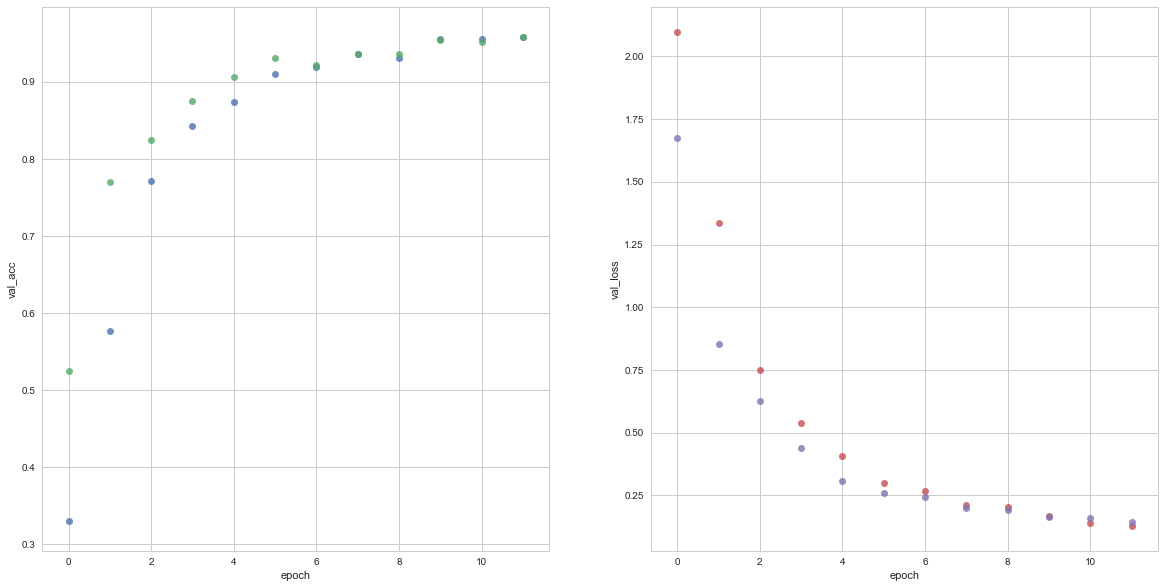

In [10]:
train_data = DataFrame({
    'epoch': train_his.epoch,
    'train_acc': train_his.history['acc'],
    'train_loss': train_his.history['loss'],
    'val_acc': train_his.history['val_acc'],
    'val_loss': train_his.history['val_loss']
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.regplot(data=train_data, x='epoch', y='train_acc', fit_reg=None, ax=ax1)
sns.regplot(data=train_data, x='epoch', y='val_acc', fit_reg=None, ax=ax1)

sns.regplot(data=train_data, x='epoch', y='train_loss', fit_reg=None, ax=ax2)
sns.regplot(data=train_data, x='epoch', y='val_loss', fit_reg=None, ax=ax2)

In [11]:
y_pred = m.predict_classes(X_test, batch_size=BATCH_SIZE)

submission = pd.DataFrame({
    "ImageId": [i+1 for i in range(test.shape[0])],
    "Label": y_pred
})
submission.to_csv('prediction.csv', index=False)

28000/28000 [==============================] - 22s    
